# Analysis of Stellar Spectra with Physics-constrainted disentangled VAE

- **Data Loading and Preprocessing**: Importing spectral data and applying masks to isolate specific regions of interest (e.g., alpha, iron, and carbon regions).
- **Model Architecture**: Utilizing a FullCovarianceVAE with separate decoders for alpha, iron, and carbon features.
- **Prediction and Reconstruction**: Generating reconstructed spectra and latent space encodings.
- **Evaluation Metrics**: Computing relative errors, precision, recall, and other metrics to assess model performance.
- **Visualization**: Plotting reconstructed spectra, residuals, and correlations between true and predicted parameters.

The notebook also investigates the impact of signal-to-noise ratio (SNR) on model performance and identifies specific stellar populations, such as Carbon-Enhanced Metal-Poor (CEMP) stars and alpha-poor, metal-poor stars.


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import shap
import matplotlib
import seaborn as sns
try:
    matplotlib.cm.register_cmap("shapcmap", shap.plots.colors.red_blue)
except:
    pass


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from utils import *
from plot_utils import *
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
cpal = sns.color_palette("shapcmap", n_colors=64, desat=1)
c0=cpal[0]
c1=cpal[-1]
sns.set_style("ticks",{"axes.facecolor":'white'})
sns.set_context("paper",font_scale=1.22)

/tmp/ipykernel_43912/3063446743.py:5: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("shapcmap", shap.plots.colors.red_blue)


In [3]:
alpha_regions = pd.read_csv("lineregions/alpha_regions.csv",sep=",") 
fe_regions = pd.read_csv("lineregions/iron_regions.csv",sep=",")
carbon_regions = pd.read_csv("lineregions/carbon_regions.csv",sep=",")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
print("Reading data...")
data_dir="/home/tsignor/Documents/rldata/"
flux = np.load(data_dir+"flux_test.npy", mmap_mode='r')
metadata = np.load(data_dir+'metadata_test.npy') #Teff, logg, FeH, aFe, CFe
wl = np.load(data_dir+'wavelengths.npy')
errors = np.load(data_dir+"errors_test.npy", mmap_mode='r')

print(flux.shape, metadata.shape, wl.shape)
Y=metadata


Reading data...
(87133, 4150) (87133, 5) (4150,)
Downsampling data to match the chemical distribution...
87133
Evaluating KDE...
(87133,)


In [6]:
# %% Filtering regions
mask_a = np.zeros_like(wl, dtype=bool)
mask_fe = np.zeros_like(wl, dtype=bool)
mask_C = np.zeros_like(wl, dtype=bool)

# Vectorized approach to update the mask
for index, row in alpha_regions.iterrows():
    mask_a = mask_a + ((wl >= row['wave_base']) & (wl <= row['wave_top']))

for index, row in fe_regions.iterrows():
    mask_fe = mask_fe + ((wl >= row['wave_base']) & (wl <= row['wave_top']))
    
for index, row in carbon_regions.iterrows():
    mask_C = mask_C+ ((wl >= row['wave_base']) & (wl <= row['wave_top']))

print("alpha mask length", mask_a.sum()/len(mask_a))
print("Iron mask length", mask_fe.sum()/len(mask_fe))
print("Carbon mask length", mask_C.sum()/len(mask_C))

overlap_mask = np.logical_and(mask_a, mask_fe+mask_C)
print("alpha overlap: ",overlap_mask.sum()/mask_a.sum())

overlap_mask = np.logical_and(mask_C, mask_fe+mask_a)
print("C-Fe overlap: ",overlap_mask.sum()/mask_C.sum())

# Remove overlaps
#mask_a_without_overlap = mask_a & ~mask_fe & ~mask_C
mask_fe_without_overlap = mask_fe & ~mask_a #& ~mask_C
mask_C_without_overlap = mask_C & ~mask_a #& ~mask_fe



mask_C=mask_C_without_overlap
mask_fe=mask_fe_without_overlap
#mask_a=mask_a_without_overlap

data_mask=torch.tensor(mask_a+mask_fe+mask_C).to(device)

print("alpha mask length", mask_a.sum()/len(mask_a))
print("Iron mask length", mask_fe.sum()/len(mask_fe))
print("Carbon mask length", mask_C.sum()/len(mask_C))


alpha mask length 0.05542168674698795
Iron mask length 0.20289156626506025
Carbon mask length 0.024819277108433735
alpha overlap:  0.13478260869565217
C-Fe overlap:  0.3106796116504854
alpha mask length 0.05542168674698795
Iron mask length 0.1966265060240964
Carbon mask length 0.020481927710843374


In [ ]:
dataset = TensorDataset(torch.tensor(flux, dtype=torch.float32), torch.tensor(errors, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=30000, shuffle=False)


In [ ]:
hparams_config = {
    "n_cat": 8, 
    "n_z": 3,
    "n_bins": flux.shape[1],
}

n_z=hparams_config["n_z"]
n_conditioned = 2


n_bins=hparams_config["n_bins"]
n_cat = hparams_config["n_cat"]

In [11]:
encoder=SpectrumEncoder()
decoder_alpha = SpectrumDecoder(n_hidden=(32, 64, 128), n_latent=3+n_conditioned, wave_rest=torch.tensor(wl[mask_a]))
decoder_fe = SpectrumDecoder(n_hidden=(32, 64, 128), n_latent=2+n_conditioned,wave_rest=torch.tensor(wl[mask_fe]))
decoder_carbon = SpectrumDecoder(n_hidden=(32, 64, 128), n_latent=2+n_conditioned,wave_rest=torch.tensor(wl[mask_C]))

discriminador = Feedforward([n_z, 64, 128, n_cat**n_conditioned],activation=nn.ReLU(),prob_out=True).to(device)
model = FullCovarianceVAE(encoder, decoder_fe,decoder_alpha,
                          decoder_carbon,
                          mask_fe, 
                          mask_a, 
                          mask_C, 
                          n_z).to(device)
model.load_state_dict(torch.load("checkpoints/best",weights_only=True, map_location=torch.device('cpu')))

print(model.count_parameters())

3340530


In [12]:
reconstruced, encoded,mu, logvar, atmpar_pred = model.predict(dataloader) 

reconstruced = reconstruced.cpu().detach().numpy()
encoded = encoded.cpu().detach().numpy()
mu = mu.cpu().detach().numpy()
logvar = logvar.cpu().detach().numpy()
atmpar_pred = atmpar_pred.cpu().detach().numpy() 

In [13]:
l2_relative_error(flux[:,data_mask.cpu().detach()], reconstruced)

0.006450274572985565

In [14]:
def expand_masked_array(reconstructed_values, mask):
    """
    Expands an array that contains only masked values to full size with NaN values
    
    Args:
        reconstructed_values: array with values only where mask is True
        mask: boolean mask array
    Returns:
        full_array: expanded array with NaN values where mask is False
    """
    full_array = np.full(mask.shape, np.nan)
    full_array[mask] = reconstructed_values
    return full_array

def mask_with_nans(array, mask):
    """
    Replace values with NaN where mask is False
    
    Args:
        array: input array to mask
        mask: boolean mask array
    Returns:
        masked_array: array with NaN values where mask is False
    """
    masked_array = array.copy()
    masked_array[~mask] = np.nan
    return masked_array


# Convert mask to numpy if it's a torch tensor
mask = data_mask.cpu().detach().numpy() if torch.is_tensor(data_mask) else data_mask



In [15]:
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
def forward(x):
    return np.exp(3*x)
def inverse(x):
    return np.log(x)/3
def plot_multiple_stars(X_test, reconstruced, y_test, wl, mask, idx_poor, idx_rich, idx_normal):
    def add_shaded_regions(ax, is_main_plot, col):
        for _, row in alpha_regions.iterrows():
            ax.axvspan(row['wave_base'], row['wave_top'], alpha=0.1, 
                      color='green', label='α-regions' if _ == 0 and is_main_plot and col == 0 else "")
        for _, row in fe_regions.iterrows():
            ax.axvspan(row['wave_base'], row['wave_top'], alpha=0.1, 
                      color='blue', label='Fe-regions' if _ == 0 and is_main_plot and col == 0 else "")
        for _, row in carbon_regions.iterrows():
            ax.axvspan(row['wave_base'], row['wave_top'], alpha=0.1, 
                      color='red', label='C-regions' if _ == 0 and is_main_plot and col == 0 else "")
    params = [r'[Fe/H]', '[α/Fe]', '[C/Fe]']

    # Create figure with three rows, each with main plot and residuals
    fig = plt.figure(figsize=(15, 15))
    # Create a new axes for the legend
    legend_ax = fig.add_axes([0.1, 0.94, 0.8, 0.02])  # [left, bottom, width, height]
    legend_ax.axis('off')
    
    # Create dummy lines for the legend
    lines = [Line2D([0], [0], color=c0, label='True'),
             Line2D([0], [0], color=c1, linestyle='dotted', label='Pred'),
             Rectangle((0,0), 1, 1, fc='green', alpha=0.1, label=r'$\alpha$-regions'),
             Rectangle((0,0), 1, 1, fc='blue', alpha=0.1, label='Fe-regions'),
             Rectangle((0,0), 1, 1, fc='red', alpha=0.1, label='C-regions')]
    
    # Add the legend
    legend_ax.legend(handles=lines, loc='center', ncol=5, 
                    frameon=True, fontsize=12)
    
    outer_gs = fig.add_gridspec(3, 1, height_ratios=[1, 1, 1], 
                               hspace=0.05, top=0.93)  # Adjusted top margin

    # Define custom scale function
    def forward(x):
        return np.exp(3*x)
    def inverse(x):
        return np.log(x)/3

    # Define titles and indices
    stars = [(idx_poor, r'$\bf{\alpha-poor, Metal-poor}$'),
            (idx_rich, r'$\bf{Carbon-rich, Metal-poor}$'),
            (idx_normal, r'$\bf{Normal\; star}$')]
    
    # Define x-axis ranges for the breaks
    ranges = [(4105, 7900), (8350, 9000), (10330, 10360)]

    for row, (idx, title) in enumerate(stars):
        inner_gs = outer_gs[row].subgridspec(2, 3, height_ratios=[3, 1], hspace=0, wspace=0.02)

        # Prepare data
        masked_test = mask_with_nans(X_test[idx], mask)
        full_reconstructed = expand_masked_array(reconstruced[idx], mask)
        l2_error = l2_relative_error(masked_test[mask], full_reconstructed[mask])
        
        # Get global y-limits for this star
        ymin = min(np.nanmin(masked_test), np.nanmin(full_reconstructed))
        ymax = max(np.nanmax(masked_test), np.nanmax(full_reconstructed)) * 1.01

        ymin_res = np.nanmin(masked_test - full_reconstructed)/1.01
        ymax_res = np.nanmax(masked_test - full_reconstructed)* 1.01



        # Plot each broken region
        for col, (xmin, xmax) in enumerate(ranges):
            # Main plot
            ax_main = fig.add_subplot(inner_gs[0, col])
            # Residual plot
            ax_res = fig.add_subplot(inner_gs[1, col])
            
            # Set shared x-axis limits
            mask_range = (wl >= xmin) & (wl <= xmax)
            
            # Plot main data
            ax_main.plot(wl[mask_range], masked_test[mask_range],c=c0, label='True' if col == 0 else '', lw=1)
            ax_main.plot(wl[mask_range], full_reconstructed[mask_range], c=c1,
                        label='Pred' if col == 0 else '', ls="dotted", lw=1)
            
            # Plot residuals
            ax_res.axhline(0, color='k', ls='--', alpha=0.5)
            ax_res.plot(wl[mask_range], 
                       masked_test[mask_range] - full_reconstructed[mask_range], 
                       color='crimson')
            
            # Configure axes
            for ax in [ax_main, ax_res]:
                ax.set_xlim(xmin, xmax)
                
                # Set scales
                if ax == ax_main:
                    ax.set_yscale('function', functions=(forward, inverse))
                    ax.set_ylim(ymin, ymax)
                else:
                    #ax.set_yscale("symlog", linthresh=1e-2)
                    ax.set_ylim(ymin_res, ymax_res)
                
                # Hide spines and ticks for middle plots
                if col == 1:
                    ax.spines['left'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                    ax.set_yticks([])
                elif col == 2:
                    ax.spines['left'].set_visible(False)
                    #ax.yaxis.tick_right()
                    ax.set_yticks([])
                elif col == 0:
                    ax.spines['right'].set_visible(False)
                
                # Add break marks
                d = 1.0  # Increased size for larger angle
                kwargs = dict(marker=[(-1, -d), (1, d)], markersize=10,
                            linestyle="none", color='k', mec='k', mew=1, clip_on=False)
                
                if col == 0:  # Left plot
                    ax.plot([1, 1], [0, 1], transform=ax.transAxes, **kwargs)
                    ax.set_ylabel("Flux")
                    ax_res.set_ylabel("Residuals")
                elif col == 1:  # Middle plot
                    ax.plot([0, 0], [0, 1], transform=ax.transAxes, **kwargs)
                    ax.plot([1, 1], [0, 1], transform=ax.transAxes, **kwargs)
                else:  # Right plot
                    ax.plot([0, 0], [0, 1], transform=ax.transAxes, **kwargs)
                
                # Handle x-axis labels
                if row < 2:  # First two stars
                    ax.set_xticks([])
                elif row == 2:  # Last star
                    if ax == ax_main:
                        ax.set_xticks([])  # Hide ticks on main plot                    
                    else:
                        
                        # Keep ticks and labels only on bottom residual plot
                        #ax.tick_params(axis='x', rotation=45)
                        if col==0:
                            ax.set_xticks(np.arange(4200, 7800,1000))
                        elif col ==1:
                            ax.set_xticks(np.arange(8400, 9000,100)
                        )
                        else:
                            ax.set_xticks(np.arange(10340, 10360,10))
                    
            # Hide x labels for main plots
            if ax == ax_main:
                ax.set_xticklabels([])
                
                
            add_shaded_regions(ax_main, True, col)
            add_shaded_regions(ax_res, False, col)
        
        # Add legend to last plot of each row
        if col == 2:
            #ax_main.legend(loc='upper right', ncol=2)
            textstr = '\n'.join([
                f'{title}',
                *[f'{p}= ${y_test[idx,j]:.2f}$' for j, p in zip([-3,-2,-1], params)],
                f'Rel. $L^2$ error: {l2_error:.2e}'
            ])
            props = dict(boxstyle='round', facecolor='white', alpha=0.5)
            ax_main.text(0.78, 0.4, textstr, transform=ax_main.transAxes,
                        fontsize=11, verticalalignment='top', 
                        horizontalalignment="right", bbox=props)
        if row == 2:  # Last row
            fig.text(0.5, 0.07, 'Wavelength [Å]', ha='center', va='bottom', fontsize=12)
    plt.show()
    return fig

In [16]:
# 1. Alpha-poor, metal-poor star
idx_poor = np.where((abs(Y[:,0] - 5500) < 200) & 
                    (Y[:,-3]<-1) & (Y[:,-2]<-0.1))[0][0]

# 2. carbon-rich, metal-poor star
idx_rich = np.where((abs(Y[:,0] - 5500) < 200) & 
                    (Y[:,-3]<-1) & (Y[:,-1]>1))[0][0]

idx_normal = np.where((abs(Y[:,0] - 5500) < 200) & 
                     (abs(Y[:,-3]) < 0.1)& 
                     (abs(Y[:,-1]) < 0.1))[0][0]


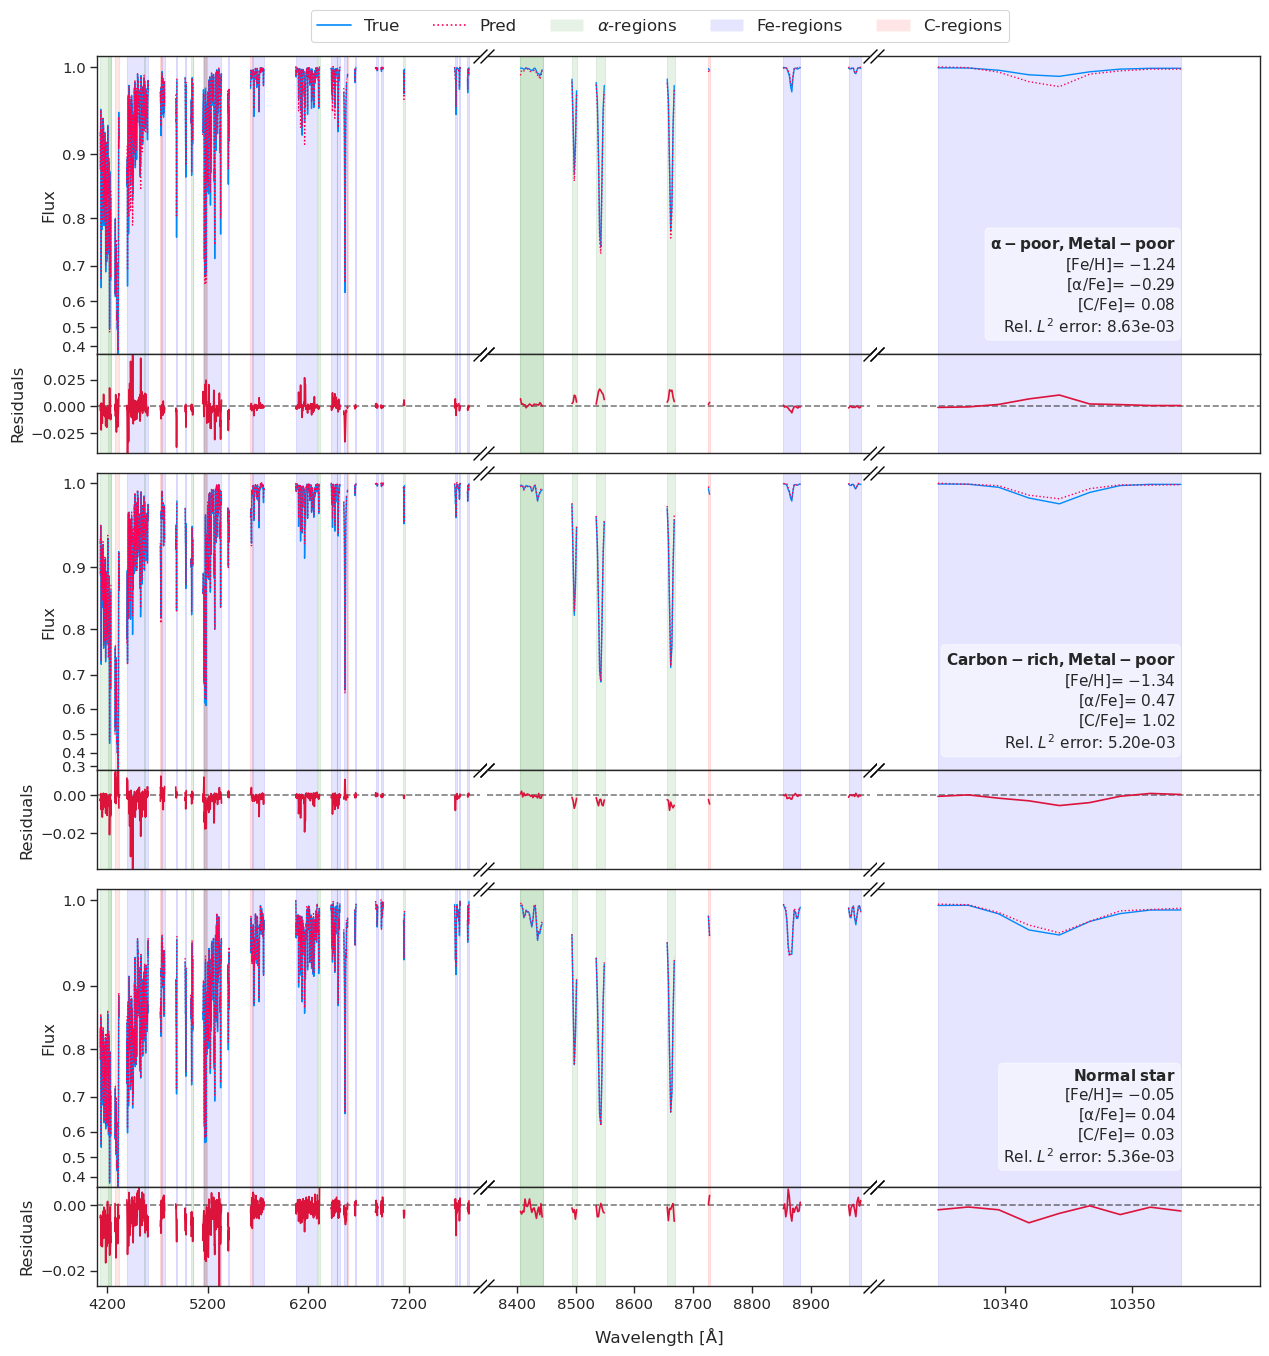

/tmp/ipykernel_43912/375918238.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


In [17]:
fig = plot_multiple_stars(flux, reconstruced, Y, wl, mask, 
                         idx_poor, idx_rich, idx_normal)
fig.tight_layout()
#fig.savefig("figures/reconstruction_example.pdf")

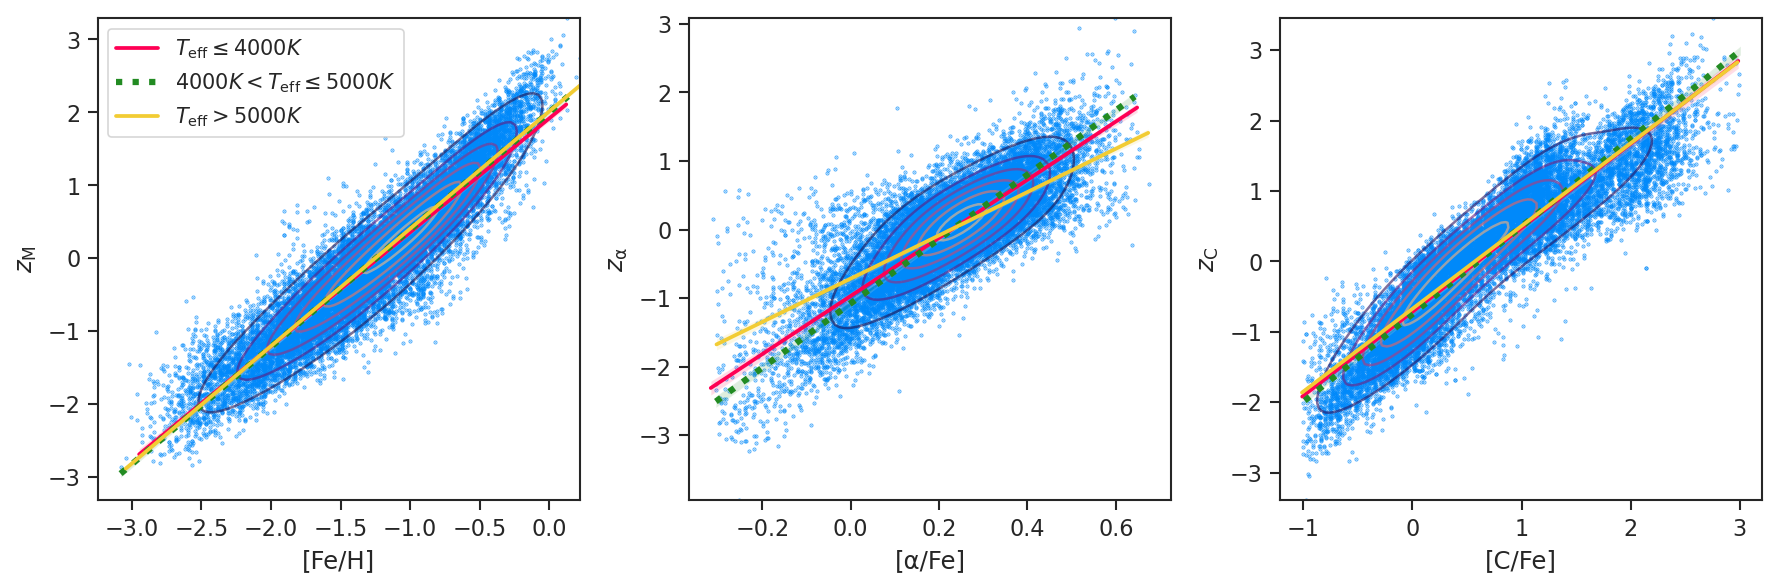

In [18]:
from scipy import stats
from matplotlib.patches import Patch

def plot_correlations(y, mu):
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 5), dpi=150)

    # Bin temperature into 3 bins
    teff = y[:, 0]
    bins = [3000,4000,5000]
    temp_bin_idx = np.digitize(teff, bins, right=True) - 1
    temp_bin_idx[temp_bin_idx == 3] = 2  # Fix rightmost edge

    temp_colors = [c1, "forestgreen", (0.95, 0.8, 0.2)]  # 3 distinct colors for bins, last is yellow
    scatter_params = {
        'alpha': 0.7,  # Transparency
        's': .2,       # Point size
        #'c': c0,   # Point color
        "lw":1.5
    }
    temp_labels=[r'$T_{\rm eff} \leq 4000K$', r'$4000K <T_{\rm eff} \leq 5000K$', r'$T_{\rm eff} >5000K$']

    for idx, (i, label) in enumerate([(-3, 'M'), (-2, "α"), (-1, 'C')]):
        xmin, xmax = y[:, i].min(), y[:, i].max()
        ymin, ymax = mu[:, i].min(), mu[:, i].max()
        xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([y[:, i], mu[:, i]])
        kernel = stats.gaussian_kde(values, bw_method=.5)
        f = np.reshape(kernel(positions).T, xx.shape)

        ax[idx].contour(xx, yy, f, levels=6, cmap='magma', alpha=0.6)

        if label=="α":
            ax[idx].scatter(y[:,i]+np.random.normal(np.zeros_like(y[:,i]),0.01), mu[:,i], color=c0,**scatter_params)
            
        else:
            ax[idx].scatter(y[:,i], mu[:,i], color=c0, **scatter_params)

        for bin_idx in range(3):
            mask = temp_bin_idx == bin_idx
            if bin_idx==1:
                sns.regplot(x=y[mask,i]+np.random.normal(np.zeros_like(y[mask,i]),0.01), y=mu[mask,i],ax=ax[idx],
                    scatter=False,ci=100,label=temp_labels[bin_idx],color=temp_colors[bin_idx],line_kws={'linestyle': "dotted","linewidth":3}
                    )
            else:
                sns.regplot(x=y[mask,i]+np.random.normal(np.zeros_like(y[mask,i]),0.01), y=mu[mask,i],ax=ax[idx],
                        scatter=False,ci=100,label=temp_labels[bin_idx],color=temp_colors[bin_idx])
            
        ax[idx].set_ylabel(r"$z_{\rm " + label + "}$")
        ax[idx].set_xlabel(f"[Fe/H]" if label == 'M' else f"[{label}/Fe]")
        ax[idx].set_box_aspect(1)
    ax[0].legend(loc='upper left', fontsize=10)
    plt.tight_layout()
    return  fig

aH = Y[:, -3] + Y[:, -2]
CH = Y[:, -3] + Y[:, -1]
newY = np.concatenate((Y[:, :4], CH[:, None]), axis=1)
fig_scatter = plot_correlations(Y, mu)

In [19]:
CEMP = (Y[:,-3]<-1.)&(Y[:,-1]>0.7)
CEMP_pred=(mu[:,-3]<-0.40)&(mu[:,-1]>0.1)

aPMP = (Y[:,-3]<-1) & (Y[:,-2]<0)
aPMP_pred = (mu[:,-2]<-1.5) & (mu[:,-3]<-0.40)


In [20]:
# Calculate metrics for both predictions and true labels
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(CEMP, CEMP_pred)

print(f"Precision CEMP: {precision[1]}")
print(f"Recall CEMP: {recall[1]}")
print(f"Support CEMP: {support[1]}")

precision, recall, fscore, support = precision_recall_fscore_support(aPMP, aPMP_pred)
print(f"Precision aPMP: {precision[1]}")
print(f"Recall aPMP: {recall[1]}")
print(f"Support aPMP: {support[1]}")


Precision CEMP: 0.9593702386998476
Recall CEMP: 0.6696207018787664
Support CEMP: 5642
Precision aPMP: 0.8805970149253731
Recall aPMP: 0.12215320910973085
Support aPMP: 483


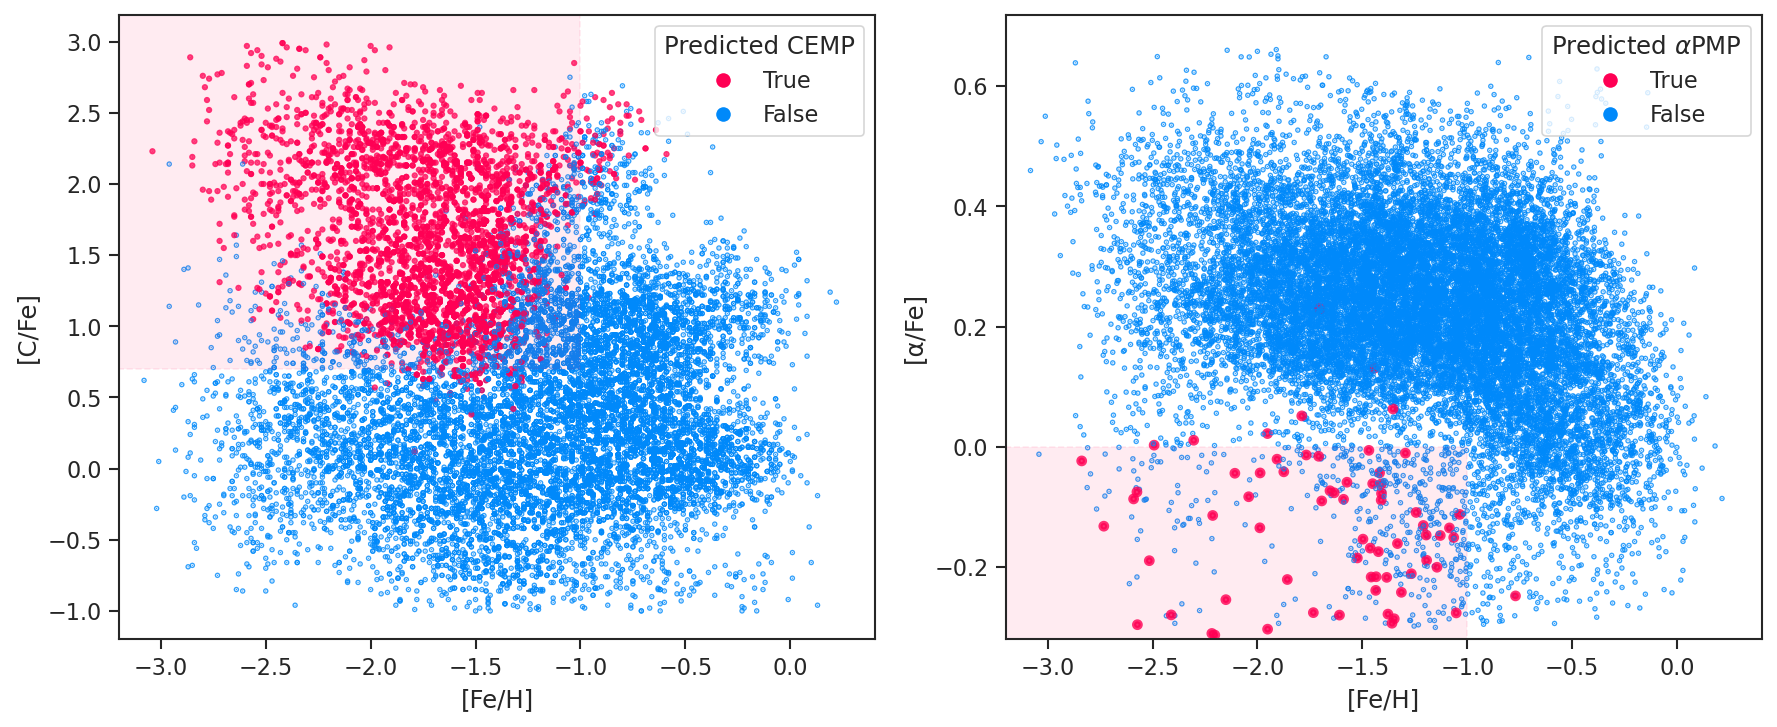

In [21]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(1,2, figsize=(12,5), dpi=150, sharex=True)
scatter_params = {
    'alpha': 0.8,  # Transparency
    's': [0.4, 1.0],  # Different sizes for False/True classes
    'lw': 2
    }

# Create color arrays with same shape as the data
colors_CEMP = np.array([c1 if pred else c0 for pred in CEMP_pred])
colors_aPMP = np.array([c1 if pred else c0 for pred in aPMP_pred])

ax[0].scatter(Y[:,2], Y[:,4], c=colors_CEMP, s=[0.4 if not pred else 1.0 for pred in CEMP_pred], **{k:v for k,v in scatter_params.items() if k != 's'})
ax[1].scatter(Y[:,-3]+np.random.normal(0,0.01,size=Y[:,-2].shape), Y[:,-2]+np.random.normal(0,0.01,size=Y[:,-2].shape), 
         c=colors_aPMP, s=[0.4 if not pred else 10.0 for pred in aPMP_pred], **{k:v for k,v in scatter_params.items() if k != 's'})

# Add rectangles to indicate regions on both plots
ax[0].add_patch(plt.Rectangle((-3.5, 0.7), 2.5, 3, 
        fill=True, linestyle='--', color=c1, alpha=0.08, zorder=1))

ax[1].add_patch(plt.Rectangle((-3.5, -0.5), 2.5, 0.5,
        fill=True, linestyle='--', color=c1, alpha=0.08,zorder=1))
ax[0].set_xlim(left=-3.2)
ax[0].set_ylim(bottom=-1.2)

ax[1].set_xlim(left=-3.2)
ax[1].set_ylim(bottom=-.32)

# Create custom legend handles
legend_CEMP = [mlines.Line2D([], [], marker='o', color='w', markerfacecolor=c1, markersize=4, label='True'),
               mlines.Line2D([], [], marker='o', color='w', markerfacecolor=c0, markersize=4, label='False')]

legend_aPMP = [mlines.Line2D([], [], marker='o', color='w', markerfacecolor=c1, markersize=4, label='True'),
               mlines.Line2D([], [], marker='o', color='w', markerfacecolor=c0, markersize=4, label='False')]

# Add legends to each subplot
ax[0].legend(handles=legend_CEMP, markerscale=2, title="Predicted CEMP")
ax[1].legend(handles=legend_aPMP, markerscale=2, loc="upper right", title="Predicted " + r"$\alpha$PMP")

# Set axis labels
ax[0].set_xlabel('[Fe/H]')
ax[0].set_ylabel('[C/Fe]')
ax[1].set_xlabel('[Fe/H]')
ax[1].set_ylabel('[α/Fe]')

# Tight layout
fig.tight_layout()
#fig.savefig("figures/anomalies_scatterplot.pdf", bbox_inches='tight')
plt.show()


# impact of SNR

In [22]:
def l2_relative_error_sample(y_true,y_pred):
    """
    Compute L2 relative error for a sample of stars
    Args:
        y_true: true spectra array
        y_pred: predicted spectra array 
    """
    # Compute relative error
    relative_error = np.sqrt(((y_true - y_pred)**2).sum(axis=1)) / \
                    np.sqrt((y_true**2).sum(axis=1))
    
    return relative_error

In [ ]:
snr=(flux/errors).mean(axis=1)

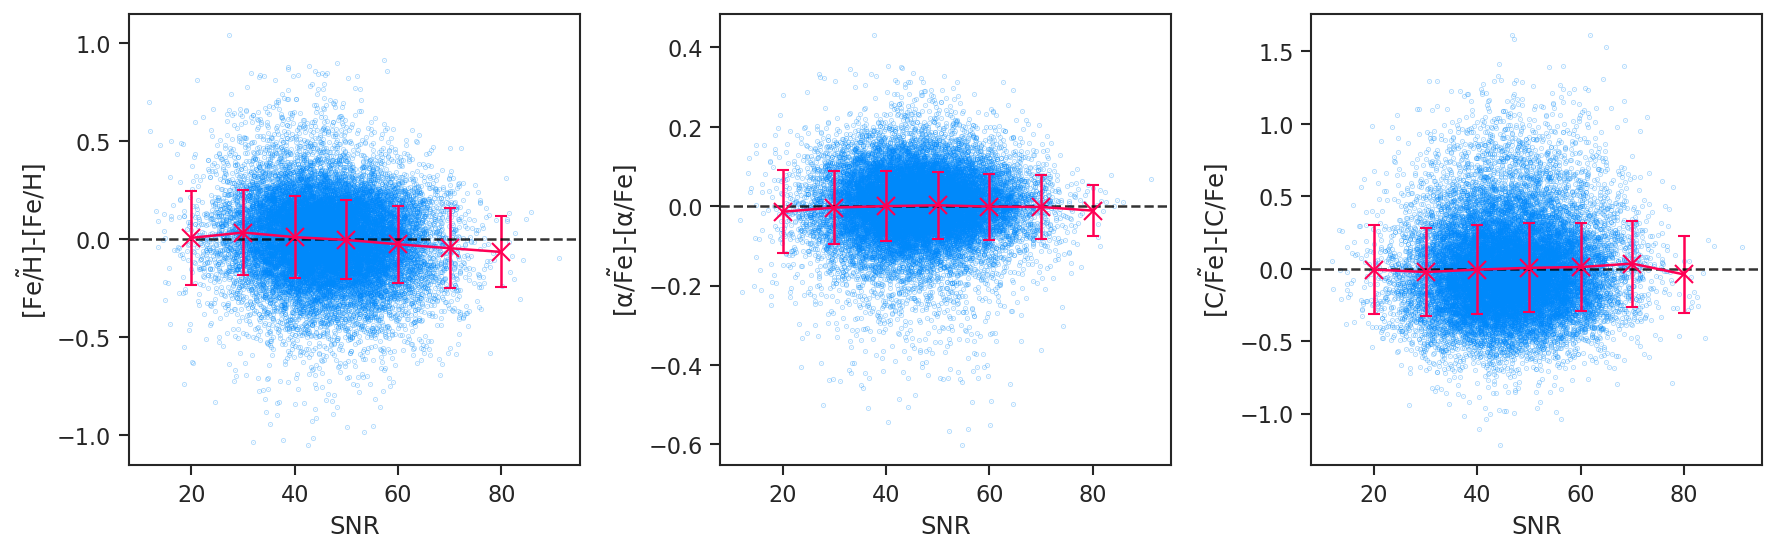

In [24]:
from sklearn.linear_model import LinearRegression
# Create figure with 3 subplots
fig, axes = plt.subplots(1,3,figsize=(12,5),dpi=150)

# Common parameters for all scatter plots
scatter_params = {
    'alpha': 0.3,  # Transparency
    's': .2,       # Point size
    'color': c0,   # Point color
    "lw":2
}

# Labels for the parameters
params = ['[Fe/H]', r'[${\rm \alpha/Fe}$]', '[C/Fe]']
params = ['[Fe/H]', '[α/Fe]', '[C/Fe]']

latents = [r'$z_{\rm M}$', r'$z_{\rm \alpha}$',r'$z_{\rm C}$']
preds = np.zeros((len(mu),3))

# Create SNR bins
spacing_bins = 10
snr_bins = np.arange(15,86, spacing_bins)
bin_centers = (snr_bins[1:] + snr_bins[:-1])/2

# Perform linear regression for each parameter
for i, (ax, param) in enumerate(zip(axes, params)):
    # Create and fit linear regression model
    reg = LinearRegression()
    X = mu[:,-3+i].reshape(-1, 1)  # Reshape for sklearn
    y = Y[:,-3+i]
    reg.fit(X, y)
    
    # Make predictions
    y_pred = reg.predict(X)
    preds[:,i] = y_pred
    y_plot = y - y_pred
    
    # Calculate binned averages
    binned_errors = []
    binned_errors_std = []
    bin_counts = []
    
    for j in range(len(snr_bins)-1):
        mask = (snr >= snr_bins[j]) & (snr < snr_bins[j+1])
        if np.sum(mask) > 0:  # Only include bins with data points
            binned_errors.append(np.mean(y_plot[mask]))
            binned_errors_std.append(np.std(y_plot[mask]))
            bin_counts.append(np.sum(mask))
    
    binned_errors = np.array(binned_errors)
    binned_errors_std = np.array(binned_errors_std)
    
    # Plot binned averages with error bars
    ax.errorbar(bin_centers[:len(binned_errors)], binned_errors, 
                yerr=binned_errors_std, fmt='x-', color=c1, 
                markersize=9, capsize=3, label='Binned average')
    ax.scatter(snr, y_plot, **scatter_params)

    
    # Add labels and formatting
    ax.set_xlabel('SNR')
    ax.set_ylabel(r"$\tilde{\rm{" + param + "}}$-"+param)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.8)
    ax.set_box_aspect(1)
plt.tight_layout()
#plt.savefig("figures/error_vs_snr.pdf", bbox_inches='tight')
plt.show()